(16661, 2) (4166, 2) (16661,) (4166,)
MAE: 0.07630623962136197
R^2: 0.9625964987424664


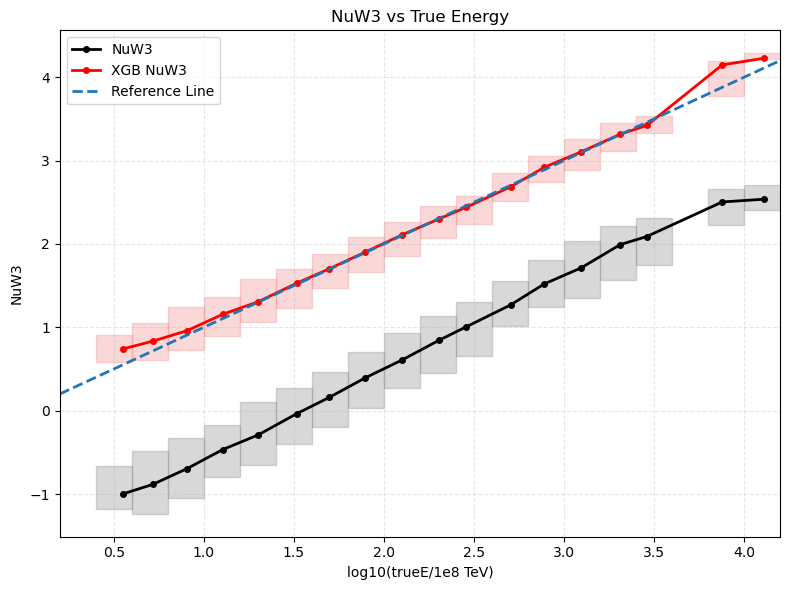

Number of bins with data: 18
X-axis range: 0.550 to 4.113


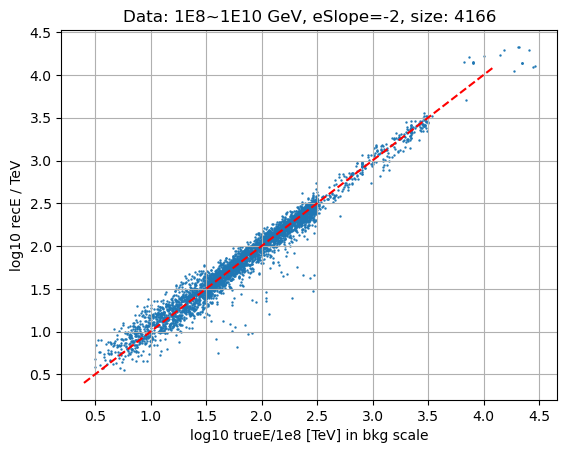

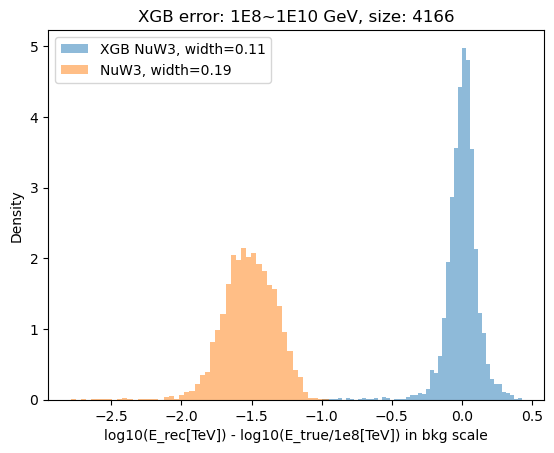

in bin=[0.05,1], monopole 1e9 GeV recE(GBR_NuW3) Energy: [0.8543363213539124, 1.3944841623306274], corresponding recE: [ 7.1505e+08,  2.4802e+09]
in bin=[0.05,1], monopole 1e10 GeV recE(GBR_NuW3) Energy: [1.8629710674285889, 2.2981839179992676], corresponding recE: [ 7.2941e+09,  1.9869e+10]


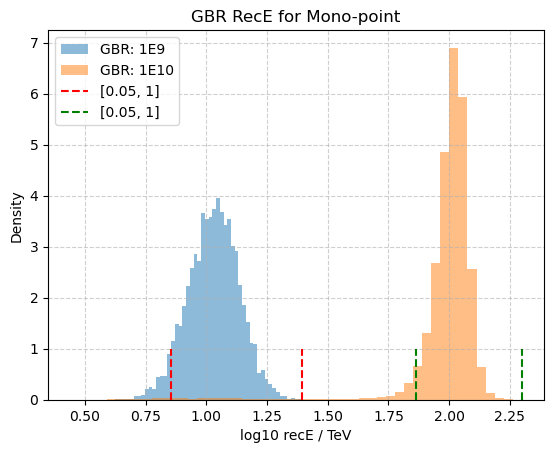

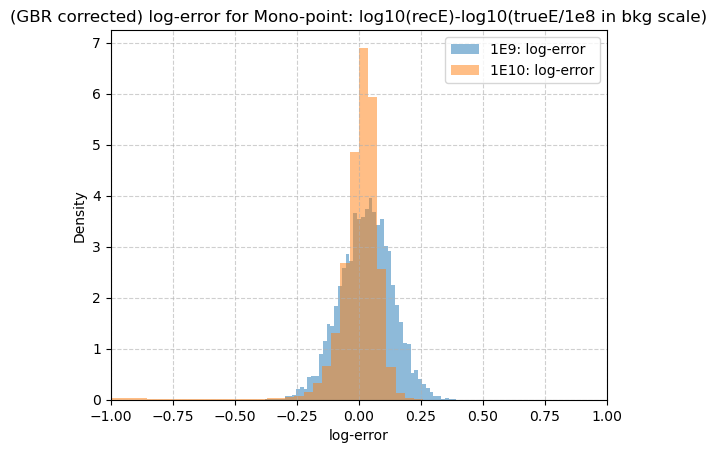

In [2]:
# energy reconstruction for monopole
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


def show_MC_data(mndata_all):
    plt.scatter(np.log10(mndata_all["trueE"]/1e8), mndata_all["NuW3"],s=0.5)
    plt.xlim(0.3,2)
    plt.ylim(0.3,3)
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(mndata_all)}")
    plt.xlabel("log10 trueE/1e8 [TeV] in bkg scale")
    plt.ylabel("NuW3")
    plt.show()

    plt.hist(mndata_all["NuW3"]-np.log10(mndata_all["trueE"]/1e8), bins=50, density=True, alpha=0.5, label=f"NuW3, width={np.std(mndata_all['NuW3']-np.log10(mndata_all['trueE']/1e8)):.2f}")
    plt.hist(mndata_all["recE"]-np.log10(mndata_all["trueE"]/1e8), bins=50, density=True, alpha=0.5,range=(-1,2), label=f"recE NpE1, width={np.std(mndata_all['recE']-np.log10(mndata_all['trueE']/1e8)):.2f}")
    plt.legend()
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(mndata_all)}")
    plt.xlabel("NuW3 - log10 trueE/1e8 [TeV] ")
    plt.ylabel("Density")
    plt.show()


def analyze_variable(all_data, energy_bins, variable="NuW3", 
                     ranges=(0.5, 3.5), target_fraction=[0.05, 0.95], 
                     ref_energy=1e9, ref_bounds=None):

    # --- 按能区收集数据 ---
    groups, labels = [], []
    for (emin, emax) in energy_bins:
        mask = (all_data['trueE'] >= emin) & (all_data['trueE'] < emax)
        subset = all_data.loc[mask, variable]
        if len(subset) > 0:
            groups.append(subset)
            labels.append(f'{emin:.1e}-{emax:.1e} GeV')

    # --- 直方图 ---
    plt.figure(figsize=(8,6))
    plt.hist(all_data[variable], bins=50, density=True,
             histtype='step', linewidth=2, color='black', label='Total', range=ranges)

    plt.hist(groups, bins=50, stacked=True, density=True,
             alpha=0.7, label=labels, range=ranges)

    if ref_bounds is not None:
        plt.vlines(ref_bounds, ymin=0, ymax=0.1, color='r', linestyle='--',
                   label=f'{ref_energy:.1e} GeV [{ref_bounds[0]:.2f}, {ref_bounds[1]:.2f}]')
    # plt.yticks([i*0.2 for i in range(11)]) 
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title(f'Stacked {variable} distribution in different trueE bins')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 取区间数据并画累积分布 ---
    if ref_bounds is None:
        return

    vmin, vmax = ref_bounds
    mask = (all_data[variable] >= vmin) & (all_data[variable] <= vmax)
    subset = all_data[mask].sort_values("trueE")

    cum_counts = np.arange(1, len(subset)+1)
    total_counts = len(subset)
    cum_fraction = cum_counts / total_counts

    idx_left = np.searchsorted(cum_fraction, target_fraction[0])
    idx_right = np.searchsorted(cum_fraction, target_fraction[1])

    energy_left = subset["trueE"].iloc[idx_left]
    energy_right = subset["trueE"].iloc[idx_right]

    print(f"{variable}: 比例达到 {target_fraction[0]:.2f} 时对应 trueE ≈ {energy_left:.3e} GeV")
    print(f"{variable}: 比例达到 {target_fraction[1]:.2f} 时对应 trueE ≈ {energy_right:.3e} GeV")

    plt.plot(np.log10(subset["trueE"]/1e8), cum_fraction, drawstyle="steps-post", 
             label=f"Fraction in {variable} [1%,99%] range")
    plt.plot(np.log10(subset["trueE"]/1e8), 1-cum_fraction, drawstyle="steps-post",
             label="1-Fraction above")

    plt.axhline(1.0, color="gray", linestyle="--")
    plt.hlines(target_fraction[0], np.log10(energy_left/1e8)-0.1,np.log10(energy_left/1e8)+0.1,color="r", linestyle="--", alpha=0.7,
                label=f'pollution frac={target_fraction}, trueE in [{energy_left:.3e}, {energy_right:.3e}]')
    plt.hlines(1-target_fraction[1], np.log10(energy_right/1e8)-0.1,np.log10(energy_right/1e8)+0.1,color="r", linestyle="--", alpha=0.7)
    plt.vlines(np.log10(energy_left/1e8), 0, 0.1, color="r", linestyle="--", alpha=0.7)
    plt.vlines(np.log10(energy_right/1e8), 0, 0.1, color="r", linestyle="--", alpha=0.7)
    plt.ylim(0, )
    plt.xlabel("log10 trueE / GeV")
    plt.ylabel("Cumulative fraction")
    plt.xlabel("log10 trueE / GeV")
    plt.ylabel("Cumulative fraction")
    plt.title(f"Cumulative fraction of events in {variable} range")
    plt.legend(loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.show()

    return energy_left, energy_right

def plot_variable_vs_energy(x, y, variable="NuW3",
                            emin=1e8, emax=1e10, 
                            delta_logE=0.1,
                            q_low=0.00, q_high=1):
   
    logE = x
    
    # mask = np.log10(all_data["trueE"]/1e8) < 1
    # all_data.loc[mask, 'NuW3'] = all_data.loc[mask, 'NuW3']

    var = y

    # 定义能量 bin
    # bins = np.arange(np.log10(emin), np.log10(emax) + delta_logE, delta_logE)
    bins=np.arange(np.min(logE), np.max(logE) + delta_logE, delta_logE)
    bin_centers, var_median, var_low, var_high = [], [], [], []

    for i in range(len(bins)-1):
        mask = (logE >= bins[i]) & (logE < bins[i+1])
        subset = var[mask]
        if len(subset) > 0:
            bin_centers.append((bins[i] + bins[i+1]) / 2)
            var_median.append(np.median(subset))
            var_low.append(np.quantile(subset, q_low))
            var_high.append(np.quantile(subset, q_high))

    bin_centers = np.array(bin_centers)
    var_median = np.array(var_median)
    var_low = np.array(var_low)
    var_high = np.array(var_high)

    # --- 绘图 ---
    # plt.figure(figsize=(8,6))
    # 用矩形柱显示范围
    for xc, low, high in zip(bin_centers, var_low, var_high):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="blue")
    # 中位数折线
    plt.plot(bin_centers, var_median, "o--", color="black", label="Median")

    plt.xlabel("log10(trueE/1e8 TeV in bkg scale)")
    plt.ylabel(variable)
    plt.title(f"{variable} range vs trueE")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()
    plt.show()

    bins=100
    plt.hist2d(x, y, bins=bins, cmap="viridis",density=True)
    plt.colorbar(label="Counts")
    plt.xlabel("log10(trueE/1e8 TeV in bkg scale)")
    plt.ylabel(variable)
    plt.title(f"{variable} vs trueE")
    # plt.grid(True, ls="--", alpha=0.5)
    plt.show()

def plot_NuW3_refined(trueE, NuW3, NuW3_refined,
                            emin=0, emax=2, 
                            delta_logE=0.1,
                            q_low=0.00, q_high=1):
   
    logE = trueE
    var_0 = NuW3
    var_1 = NuW3_refined

    # 定义能量 bin
    bins = np.arange(emin, emax + delta_logE, delta_logE)
    bin_centers_0, var_median_0, var_low_0, var_high_0 = [], [], [], []
    bin_centers_1, var_median_1, var_low_1, var_high_1 = [], [], [], []
    
    # 新增：存储每个bin内数据的平均值
    bin_avg_0, bin_avg_1 = [], []

    for i in range(len(bins)-1):
        mask = (logE >= bins[i]) & (logE < bins[i+1])
        subset_0 = var_0[mask]
        subset_1 = var_1[mask]
        subset_logE = logE[mask]  # 获取当前bin内的logE值
        
        if len(subset_0) > 0:
            # 使用bin内数据的平均值作为x坐标
            bin_centers_0.append((bins[i] + bins[i+1]) / 2)
            bin_avg_0.append(np.mean(subset_logE))
            var_median_0.append(np.median(subset_0))
            var_low_0.append(np.quantile(subset_0, q_low))
            var_high_0.append(np.quantile(subset_0, q_high))
            
        if len(subset_1) > 0:
            # 使用bin内数据的平均值作为x坐标
            bin_centers_1.append((bins[i] + bins[i+1]) / 2)
            bin_avg_1.append(np.mean(subset_logE))
            var_median_1.append(np.median(subset_1))
            var_low_1.append(np.quantile(subset_1, q_low))
            var_high_1.append(np.quantile(subset_1, q_high))

    bin_avg_0 = np.array(bin_avg_0)
    var_median_0 = np.array(var_median_0)
    var_low_0 = np.array(var_low_0)
    var_high_0 = np.array(var_high_0)

    bin_avg_1 = np.array(bin_avg_1)
    var_median_1 = np.array(var_median_1)
    var_low_1 = np.array(var_low_1)
    var_high_1 = np.array(var_high_1)

    # --- 绘图 ---
    plt.figure(figsize=(8,6))
    
    # 用矩形柱显示范围 - 原始NuW3
    for xc, low, high in zip(bin_centers_0, var_low_0, var_high_0):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="gray")
    
    # 用矩形柱显示范围 - 修正后的NuW3
    for xc, low, high in zip(bin_centers_1, var_low_1, var_high_1):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="lightcoral")
    
    # 中位数折线 - 使用bin内数据的平均值作为x坐标
    plt.plot(bin_avg_0, var_median_0, "o-", color="black", linewidth=2, markersize=4, label="NuW3")
    plt.plot(bin_avg_1, var_median_1, "o-", color="red", linewidth=2, markersize=4, label="XGB NuW3")
    
    # 参考线
    plt.plot([emin, emax], [emin, emax], "--", linewidth=2, label="Reference Line")
    
    plt.xlabel("log10(trueE/1e8 TeV)")
    plt.ylabel("NuW3")
    plt.title("NuW3 vs True Energy")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xlim(emin, emax)
    plt.tight_layout()
    plt.show()
    
    # 打印一些统计信息
    print(f"Number of bins with data: {len(bin_avg_0)}")
    print(f"X-axis range: {bin_avg_0.min():.3f} to {bin_avg_0.max():.3f}")

def  plot_estimation():
    # 训练后
    plot_NuW3_refined(y_test, X_test_p["NuW3"], y_pred, emin=0.2, emax=4.2, delta_logE=0.2, q_low=0.025, q_high=0.975)


    plt.scatter(y_test, y_pred, s=0.5)
    plt.plot([0.4, 4.1], [0.4, 4.1], color='r', linestyle='--')
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(y_pred)}")
    plt.xlabel("log10 trueE/1e8 [TeV] in bkg scale")
    plt.ylabel("log10 recE / TeV")
    plt.grid()
    plt.show()


    plt.hist(y_pred-y_test, bins=50, density=True, alpha=0.5,label=f"XGB NuW3, width={np.std(y_pred-y_test):.2f}")
    plt.hist(X_test["NuW3"]-y_test, bins=50, density=True, alpha=0.5, label=f"NuW3, width={np.std(X_test['NuW3']-y_test):.2f}")
    plt.legend()
    plt.title(f"XGB error: 1E8~1E10 GeV, size: {len(y_pred)}")
    plt.xlabel("log10(E_rec[TeV]) - log10(E_true/1e8[TeV]) in bkg scale")
    plt.ylabel("Density")
    plt.show()

    # errbar(y_test, y_pred, X_test_p["recE"], labels=["XBG NuW3", "recE NpE1"])

    from sklearn.metrics import mean_absolute_error, r2_score
    import joblib  # 用于保存模型
    # loaded_model = joblib.load("./models/energy_correction_xgb_NuW3_8-12.pkl")
    # loaded_model = joblib.load("./models/energy_correction_MLP_optimized.pkl")['model']
    # loaded_model = joblib.load("./models/energy_correction_gb_NuW3.pkl")
    model = XGBRegressor()
    model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    mndata_point_90=pd.read_csv('./points/combined_points1e9_M_params.csv',sep=',')
    mn_1e10=np.load("/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz", allow_pickle=True)
    mn_1e10=pd.DataFrame(mn_1e10['params'], columns=mn_1e10['param_names'])
    mn_1e10['NuW3']= pd.to_numeric(mn_1e10['NuW3'], errors='coerce')
    mn_1e10['rec_theta'] = pd.to_numeric(mn_1e10['rec_theta'], errors='coerce')
    mn_1e10['dr']= pd.to_numeric(mn_1e10['dr'], errors='coerce')
    mn_1e10['trueE'] = pd.to_numeric(mn_1e10['trueE'], errors='coerce')
    mndata_point_100=mn_1e10[ (mn_1e10['dr']>0) & (mn_1e10['rec_theta']>0) & (mn_1e10['rec_theta']<=70/180*np.pi)].copy()

    bins=50
    ranges=(0,3)

    mndata_point_90['NuW3']=np.log10(mndata_point_90['NuW3'])
    mndata_point_100['NuW3']=np.log10(mndata_point_100['NuW3'])
    X_test_90=mndata_point_90[['NuW3','rec_theta']].values
    y_pred_90 = model.predict(X_test_90)
    X_test_100=mndata_point_100[['NuW3','rec_theta']].values
    y_pred_100 = model.predict(X_test_100)


    # 同样筛选中间90%的数据,左右两边分别去掉1%
    ratio_left=0.05
    ratio_right=1
    size_90=len(y_pred_90)
    size_100=len(y_pred_100)

    y_pred_90_selected=np.sort(y_pred_90,axis=0)[int(size_90*ratio_left):int(size_90*ratio_right)]
    y_pred_100_selected=np.sort(y_pred_100,axis=0)[int(size_100*ratio_left):int(size_100*ratio_right)]
    print(f"in bin=[{ratio_left},{ratio_right}], monopole 1e9 GeV recE(GBR_NuW3) Energy: [{y_pred_90_selected.min()}, {y_pred_90_selected.max()}], corresponding recE: [{10**y_pred_90_selected.min()*1e8: .4e}, {10**y_pred_90_selected.max()*1e8: .4e}]")
    print(f"in bin=[{ratio_left},{ratio_right}], monopole 1e10 GeV recE(GBR_NuW3) Energy: [{y_pred_100_selected.min()}, {y_pred_100_selected.max()}], corresponding recE: [{10**y_pred_100_selected.min()*1e8: .4e}, {10**y_pred_100_selected.max()*1e8: .4e}]")
    plt.hist(y_pred_90, bins=50, density=True, alpha=0.5, label='GBR: 1E9')
    plt.hist(y_pred_100, bins=50, density=True, alpha=0.5, label='GBR: 1E10')
    plt.vlines(y_pred_90_selected.min(), 0, 1, color='r', linestyle='--',label=f'[{ratio_left}, {ratio_right}]')
    plt.vlines(y_pred_90_selected.max(), 0, 1, color='r', linestyle='--')
    plt.vlines(y_pred_100_selected.min(), 0, 1, color='g', linestyle='--',label=f'[{ratio_left}, {ratio_right}]')
    plt.vlines(y_pred_100_selected.max(), 0, 1, color='g', linestyle='--')
    plt.xlabel('log10 recE / TeV')
    plt.ylabel('Density')
    plt.title('GBR RecE for Mono-point')
    plt.grid(True, ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    plt.hist(y_pred_90-np.log10(mndata_point_90['trueE']/1e8), bins=50, alpha=0.5, density=True,label='1E9: log-error')
    plt.hist(y_pred_100-np.log10(mndata_point_100['trueE']/1e8), bins=50, alpha=0.5, density=True,label='1E10: log-error')
    plt.xlim(-1,1)
    plt.grid(True, ls='--', alpha=0.6)
    plt.xlabel('log-error')
    plt.ylabel('Density')
    plt.title('(GBR corrected) log-error for Mono-point: log10(recE)-log10(trueE/1e8 in bkg scale)')
    plt.legend()
    plt.show()

def XGB_train(X_train, y_train, X_test, y_test):
    
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.03
        ,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        # monotone_constraints='(1, 0)',
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))
    model.save_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    # 加载模型
    # model = XGBRegressor()
    # model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    # joblib.dump(model, "./models/energy_correction_xgb_NuW3_8-12.pkl")

    return y_pred

# ---------------------------------------------------------
# 定义简单的 MLP 网络结构 (也可以放在函数外)
# ---------------------------------------------------------
class EnergyPredictor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

def MLP_train(X_train, y_train, X_test, y_test):
    # ==========================================
    # 1. 数据预处理 (Standardization) - MLP 必须步骤
    # ==========================================
    scaler = StandardScaler()
    # 转换为 numpy 并归一化
    X_train_scaled = scaler.fit_transform(X_train.values.astype(np.float32))
    X_test_scaled = scaler.transform(X_test.values.astype(np.float32))

    # 目标值 y 也需要转为 tensor (N, 1)
    y_train_np = y_train.values.astype(np.float32).reshape(-1, 1)
    y_test_np = y_test.values.astype(np.float32).reshape(-1, 1)

    # 转为 PyTorch Tensor
    X_train_tensor = torch.from_numpy(X_train_scaled)
    y_train_tensor = torch.from_numpy(y_train_np)
    X_test_tensor = torch.from_numpy(X_test_scaled)

    # 创建 DataLoader 用于批处理
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    # ==========================================
    # 2. 模型初始化与配置
    # ==========================================
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnergyPredictor(input_dim=X_train.shape[1]).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # ==========================================
    # 3. 训练循环
    # ==========================================
    epochs = 100
    print(f"Start Training MLP on {device}...")
    
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # 可选：每 50 epoch 打印一次 loss
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    # ==========================================
    # 4. 评估与保存
    # ==========================================
    model.eval()
    with torch.no_grad():
        # 预测测试集
        X_test_tensor = X_test_tensor.to(device)
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.cpu().numpy().flatten() # 转回 numpy 方便后续处理

    print("-" * 30)
    print("MLP Evaluation:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))
    print("-" * 30)

    # 保存模型参数
    torch.save(model.state_dict(), "./models/energy_correction_mlp_NuW3_8-12.pth")
    # 【重要】必须保存 scaler，否则将来无法预测新数据
    joblib.dump(scaler, "./models/energy_correction_mlp_scaler.pkl")
    print("Model and Scaler saved to ./models/")

    return y_pred


def filter_data(mndata_all):
    theta_low = 0.0
    theta_high = 50/180.0 * np.pi
    rec_r_high=600
    rec_r_low=250
    rec_x = pd.to_numeric(mndata_all['rec_x'], errors='coerce')
    rec_y = pd.to_numeric(mndata_all['rec_y'], errors='coerce')
    rec_r = np.sqrt(rec_x**2 + rec_y**2)
    mndata_all['rec_r'] = rec_r
    mndata_all_filtered = mndata_all[
        (mndata_all['rec_theta'] >= theta_low) &
        (mndata_all['rec_theta'] <= theta_high) &
        (mndata_all['rec_r'] >= rec_r_low) &
        (mndata_all['rec_r'] <= rec_r_high) &
        (mndata_all['NuW3'] > 0)
    ].copy()
    del mndata_all
    mndata_all_filtered['trueE'] = pd.to_numeric(mndata_all_filtered['trueE'], errors='coerce')
    mndata_all_filtered['recE'] = pd.to_numeric(mndata_all_filtered['recE'], errors='coerce')
    mndata_all_filtered['NuW3'] = pd.to_numeric(mndata_all_filtered['NuW3'], errors='coerce')
    mndata_all_filtered['rec_theta'] = pd.to_numeric(mndata_all_filtered['rec_theta'], errors='coerce')
    return mndata_all_filtered

def pd_params_concat(params_list):
    mndata_all=pd.DataFrame()
    columns=['trueE','recE','NuW3','rec_theta','rec_x','rec_y']
    for params in params_list:
        mndata_all=pd.concat([mndata_all,params[columns]],ignore_index=True)
    return mndata_all


mn_data=np.load("/home/zhonghua/data/Dataset_Filted/Monopole/filted_all_recE_0.5_4.5_dataset_muon.npz", allow_pickle=True)
mn_df = pd.DataFrame(mn_data['params'], columns=mn_data['param_names'])
mn_df['NuW3']= pd.to_numeric(mn_df['NuW3'], errors='coerce')
mn_df['rec_theta'] = pd.to_numeric(mn_df['rec_theta'], errors='coerce')
mn_df['dr']= pd.to_numeric(mn_df['dr'], errors='coerce')
mn_df['trueE'] = pd.to_numeric(mn_df['trueE'], errors='coerce')
mn_df['NuW3'] = np.log10(mn_df['NuW3'])



mn_lowE = mn_df[mn_df['trueE']<3.16e9].copy()
mn_highE = mn_df[mn_df['trueE']>=3.16e9].copy()
mn_lowE_sampled = mn_lowE.sample(frac=0.3, random_state=42)
mn_df = pd.concat([mn_lowE_sampled, mn_highE], ignore_index=True)
mn_df_train=mn_df[ (mn_df['dr']>0) & (mn_df['rec_theta']>0) & (mn_df['rec_theta']<=70/180*np.pi)].copy()
# (mn_df['NuW3']>=0) &


# 划分训练集和测试集
X_train_p, X_test_p, y_train, y_test = train_test_split(mn_df_train[['NuW3','rec_theta']], np.log10(mn_df_train['trueE']/1e8), test_size=0.2, random_state=42)
print(X_train_p.shape, X_test_p.shape, y_train.shape, y_test.shape)
X_train= X_train_p[['NuW3','rec_theta']]
X_test = X_test_p[['NuW3','rec_theta']]
y_pred = XGB_train(X_train, y_train, X_test, y_test)
# y_pred = GBR_train(X_train, y_train, X_test, y_test)
# y_pred = MLP_train(X_train, y_train, X_test, y_test)
# y_pred = MLP_train_optimized(X_train, y_train, X_test, y_test)
# y_pred = MLP_train_weighted(X_train, y_train, X_test, y_test)
# y_pred = compare_models(X_train, y_train, X_test, y_test)
# model = joblib.load("./models/energy_correction_gb_NuW3.pkl")
# y_pred = model.predict(X_test)

plot_estimation()


In [42]:
1.2**10


6.191736422399997

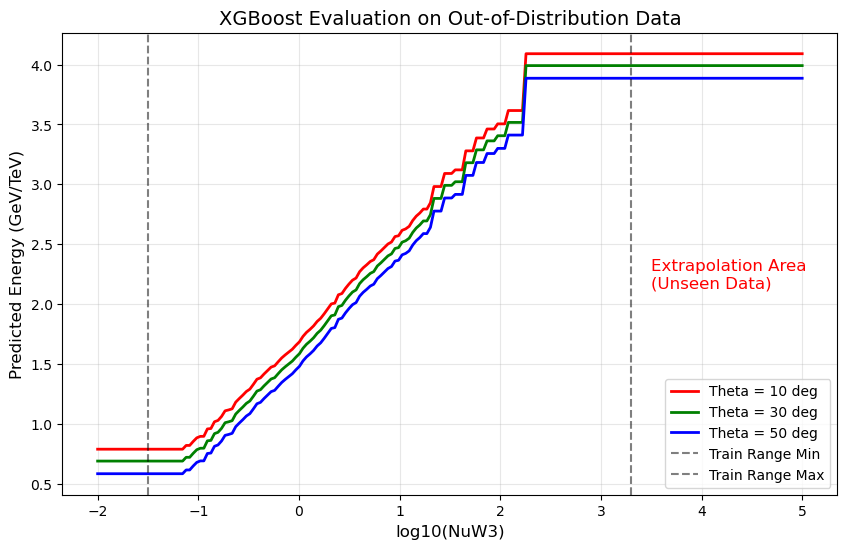

In [44]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# ---------------------------------------------------------
# 1. 准备工作：加载模型 (假设模型刚训练完就在内存里，或者从文件加载)
# ---------------------------------------------------------
# 如果 model 还在内存里，直接用。如果在新的脚本里，取消下面注释加载：
model = xgb.XGBRegressor()
model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")

# ---------------------------------------------------------
# 2. 定义数据范围
# ---------------------------------------------------------
# 训练集的大致范围 (用于画图时的参考线)
train_min_nuw3, train_max_nuw3 = -1.5, 3.3

# 生成假数据范围：向左扩展到 -2.0，向右扩展到 5.0 (模拟更高能段)
fake_nuw3 = np.linspace(-2.0, 5.0, 200)

# 固定几个典型的 theta 角来观察 (例如: 0度, 20度, 40度)
# 注意：训练时用了弧度，这里需保持一致。如果 rec_theta 也就是 0~70度
thetas_deg = [10, 30, 50] 
thetas_rad = [t / 180 * np.pi for t in thetas_deg]

# ---------------------------------------------------------
# 3. 生成测试数据并预测
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b']

for i, theta in enumerate(thetas_rad):
    # 构造 DataFrame，列名必须与训练时完全一致
    fake_df = pd.DataFrame({
        'NuW3': fake_nuw3,
        'rec_theta': np.full_like(fake_nuw3, theta)
    })
    
    # 预测 (得到的是 log10(E/1e8))
    pred_log = model.predict(fake_df)
    
    # 还原回真实能量 (True Energy)
    # y = log10(E/1e8) -> E = 10^y * 1e8
    pred_energy = pred_log
    
    # ---------------------------------------------------------
    # 4. 绘图评估
    # ---------------------------------------------------------
    label_str = f'Theta = {thetas_deg[i]} deg'
    plt.plot(fake_nuw3, pred_energy, color=colors[i], label=label_str, linewidth=2)

# ---------------------------------------------------------
# 5. 添加辅助线和标注
# ---------------------------------------------------------
# 绘制训练集边界
plt.axvline(x=train_min_nuw3, color='k', linestyle='--', alpha=0.5, label='Train Range Min')
plt.axvline(x=train_max_nuw3, color='k', linestyle='--', alpha=0.5, label='Train Range Max')

# 标注区域
plt.text(train_max_nuw3 + 0.2, plt.ylim()[1]*0.5, 'Extrapolation Area\n(Unseen Data)', fontsize=12, color='red')

# plt.yscale('log') # 能量通常跨度大，建议用对数坐标看
plt.xlabel('log10(NuW3)', fontsize=12)
plt.ylabel('Predicted Energy (GeV/TeV)', fontsize=12)
plt.title('XGBoost Evaluation on Out-of-Distribution Data', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()


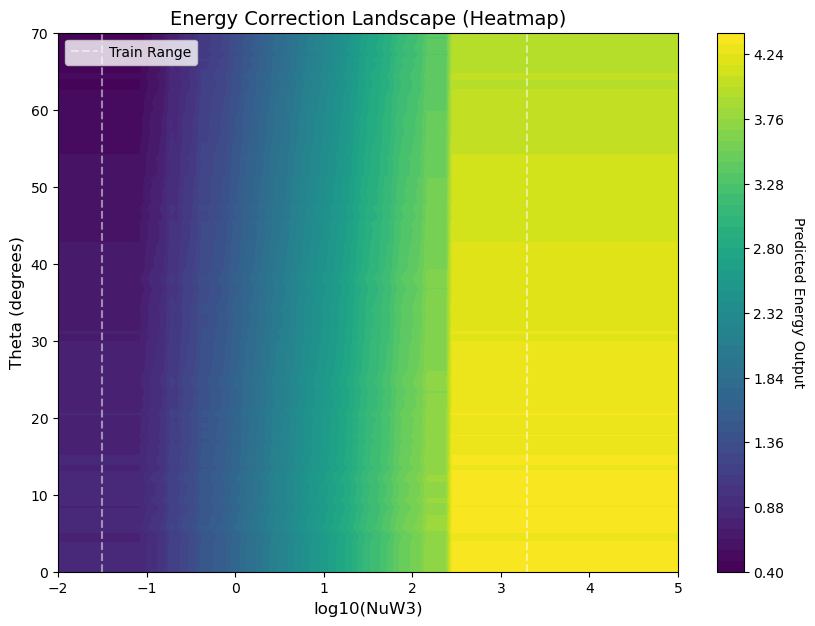

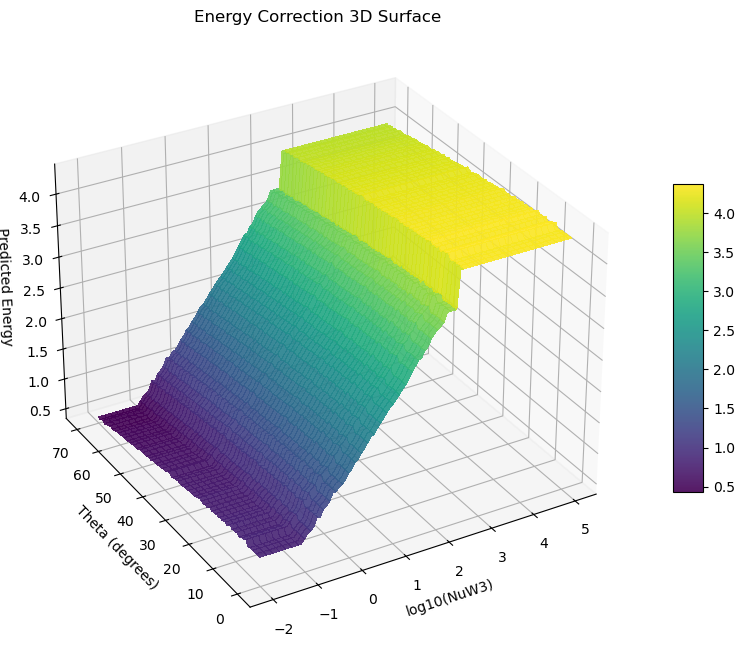

In [3]:
model = xgb.XGBRegressor()
model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb # 实际使用时需要

# ---------------------------------------------------------
# 1. 准备数据：生成 2D 网格
# ---------------------------------------------------------
# 分辨率：点越多图越平滑
n_points_nuw3 = 100
n_points_theta = 100

# 定义范围
nuw3_vals = np.linspace(-2.0, 5.0, n_points_nuw3)
theta_deg_vals = np.linspace(0, 70, n_points_theta)
theta_rad_vals = np.radians(theta_deg_vals) # 转换成弧度供模型使用

# 创建网格 (Meshgrid)
X, Y_rad = np.meshgrid(nuw3_vals, theta_rad_vals)
X, Y_deg = np.meshgrid(nuw3_vals, theta_deg_vals) # 用于画图的 Y 轴 (角度)

# 展平以便输入给 DataFrame
flat_nuw3 = X.ravel()
flat_theta_rad = Y_rad.ravel()

fake_df = pd.DataFrame({
    'NuW3': flat_nuw3,
    'rec_theta': flat_theta_rad
})

# ---------------------------------------------------------
# 2. 模型预测
# ---------------------------------------------------------
# 假设 model 已经加载好:
# model = xgb.XGBRegressor()
# model.load_model("...")
# 这里使用之前定义的模拟模型代替进行演示：
# pred_series = model.predict(fake_df)
# 如果是真实模型返回的是 numpy array，直接用即可；如果是 Series，加 .values
# Z_flat = pred_series 

# 为了让代码可运行，我这里直接用假数据填充 Z_flat
# 实际请替换为：Z_flat = model.predict(fake_df)
Z_flat = model.predict(fake_df)

# 重塑回网格形状 (100, 100)
Z = Z_flat.values.reshape(X.shape) if hasattr(Z_flat, 'values') else Z_flat.reshape(X.shape)

# ---------------------------------------------------------
# 3. 绘图：热力图 (Contourf)
# ---------------------------------------------------------
plt.figure(figsize=(10, 7))

# levels=50 让颜色过渡看起来是连续的
contour = plt.contourf(X, Y_deg, Z, levels=50, cmap='viridis')

# 添加色条
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Energy Output', rotation=270, labelpad=15)

# 添加辅助线
plt.axvline(x=-1.5, color='white', linestyle='--', alpha=0.5, label='Train Range')
plt.axvline(x=3.3, color='white', linestyle='--', alpha=0.5)

plt.xlabel('log10(NuW3)', fontsize=12)
plt.ylabel('Theta (degrees)', fontsize=12)
plt.title('Energy Correction Landscape (Heatmap)', fontsize=14)
plt.legend(loc='upper left')
plt.show()
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


# 绘制曲面
surf = ax.plot_surface(X, Y_deg, Z, cmap='viridis', linewidth=0, antialiased=False, alpha=0.9)

ax.set_xlabel('log10(NuW3)')
ax.set_ylabel('Theta (degrees)')
ax.set_zlabel('Predicted Energy')
ax.set_title('Energy Correction 3D Surface')

# 添加色条
fig.colorbar(surf, shrink=0.5, aspect=10)

# 调整视角 (仰角 30度, 方位角 -120度)
ax.view_init(elev=30, azim=-120)
plt.show()


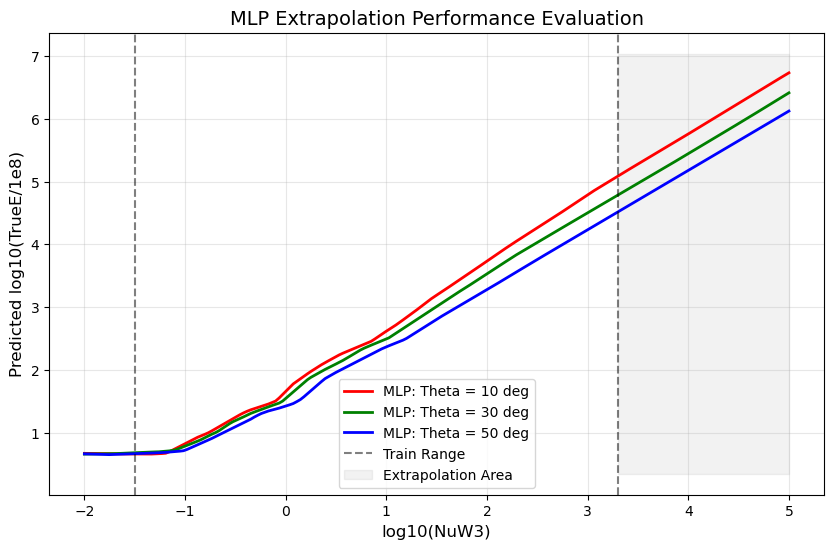

In [38]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# ---------------------------------------------------------
# 1. 准备工作：加载模型和 Scaler
# ---------------------------------------------------------
# 加载训练时保存的标准化工具 (必须)
scaler = joblib.load("./models/energy_correction_mlp_scaler.pkl")

# 定义与训练时一致的网络结构
class EnergyPredictor(nn.Module):
    def __init__(self, input_dim=2):
        super(EnergyPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# 加载权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyPredictor(input_dim=2).to(device)
model.load_state_dict(torch.load("./models/energy_correction_mlp_NuW3_8-12.pth"))
model.eval()

# ---------------------------------------------------------
# 2. 定义评估数据范围
# ---------------------------------------------------------
train_min_nuw3, train_max_nuw3 = -1.5, 3.3
fake_nuw3 = np.linspace(-2.0, 5.0, 200) # 包含外推区域

thetas_deg = [10, 30, 50] 
thetas_rad = [t / 180 * np.pi for t in thetas_deg]

# ---------------------------------------------------------
# 3. 预测与绘图
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']

with torch.no_grad():
    for i, theta in enumerate(thetas_rad):
        # A. 构造原始 DataFrame (确保列序与训练时 X_train 一致)
        fake_df = pd.DataFrame({
            'NuW3': fake_nuw3,
            'rec_theta': np.full_like(fake_nuw3, theta)
        })
        
        # B. 【关键】执行标准化转换
        # 使用训练时拟合好的 scaler 将假数据转为 Z-score
        fake_scaled = scaler.transform(fake_df.values.astype(np.float32))
        
        # C. 转为 Tensor 并预测
        fake_tensor = torch.from_numpy(fake_scaled).to(device)
        pred_log = model(fake_tensor).cpu().numpy().flatten()
        
        # D. 还原能量 (如果 y 训练时是 log10(E/1e8))
        # 如果你想直接看 log 分布，就用 pred_log；看真实值就还原
        # pred_energy = (10 ** pred_log) * 1e8 
        pred_energy = pred_log # 这里保持与你提供的代码逻辑一致，看 log 空间
        
        # 绘图
        label_str = f'MLP: Theta = {thetas_deg[i]} deg'
        plt.plot(fake_nuw3, pred_energy, color=colors[i], label=label_str, linewidth=2)

# ---------------------------------------------------------
# 4. 辅助线与标注
# ---------------------------------------------------------
plt.axvline(x=train_min_nuw3, color='k', linestyle='--', alpha=0.5, label='Train Range')
plt.axvline(x=train_max_nuw3, color='k', linestyle='--', alpha=0.5)

# 标注外推区
plt.fill_between([train_max_nuw3, 5.0], plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.1, label='Extrapolation Area')

plt.xlabel('log10(NuW3)', fontsize=12)
plt.ylabel('Predicted log10(TrueE/1e8)', fontsize=12)
plt.title('MLP Extrapolation Performance Evaluation', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()


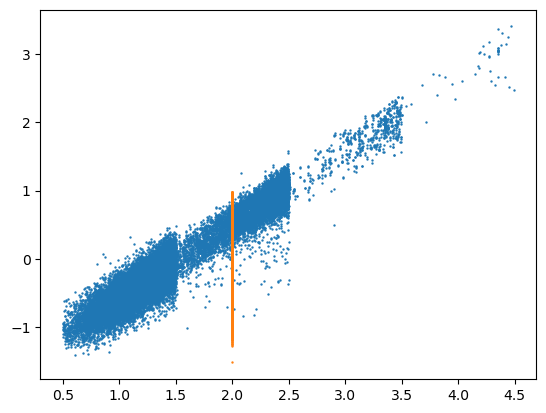

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mn_1e10=np.load("/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz", allow_pickle=True)
mn_1e10=pd.DataFrame(mn_1e10['params'], columns=mn_1e10['param_names'])
mn_1e10['NuW3']= pd.to_numeric(mn_1e10['NuW3'], errors='coerce')
mn_1e10['rec_theta'] = pd.to_numeric(mn_1e10['rec_theta'], errors='coerce')
mn_1e10['dr']= pd.to_numeric(mn_1e10['dr'], errors='coerce')
mn_1e10['trueE'] = pd.to_numeric(mn_1e10['trueE'], errors='coerce')
mn_1e10['NuW3'] = np.log10(mn_1e10['NuW3'])
mn_100=mn_1e10[ (mn_1e10['dr']>0) & (mn_1e10['rec_theta']>0) & (mn_1e10['rec_theta']<=70/180*np.pi)].copy()



plt.scatter(np.log10(mn_df["trueE"]/1e8), mn_df['NuW3'],s=0.5)
plt.scatter(np.log10(mn_100["trueE"]/1e8), mn_100['NuW3'],s=0.5)
plt.show()


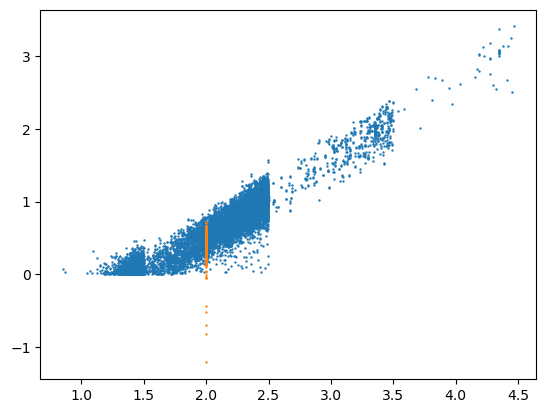

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mn_100=pd.read_csv("/home/zhonghua/Filt_Event/recE/points/combined_points1e10_M_params.csv")


plt.scatter(np.log10(mndata_all_train["trueE"]/1e8), mndata_all_train['NuW3'],s=0.5)
plt.scatter(np.log10(mn_100["trueE"]/1e8), np.log10(mn_100['NuW3']),s=0.5)
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


mn_1e10=np.load("/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz", allow_pickle=True)
mn_1e10=pd.DataFrame(mn_1e10['params'], columns=mn_1e10['param_names'])
mn_1e10['NuW3']= pd.to_numeric(mn_1e10['NuW3'], errors='coerce')
mn_1e10['rec_theta'] = pd.to_numeric(mn_1e10['rec_theta'], errors='coerce')
mn_1e10['dr']= pd.to_numeric(mn_1e10['dr'], errors='coerce')
mn_1e10['trueE'] = pd.to_numeric(mn_1e10['trueE'], errors='coerce')
mn_1e10['NuW3'] = np.log10(mn_1e10['NuW3'])
mn_1e10_good=mn_1e10[ (mn_1e10['dr']>0) & (mn_1e10['rec_theta']>0) & (mn_1e10['rec_theta']<=70/180*np.pi)].copy()

print(mn_1e10[mn_1e10['recE']>1.8629].shape)



(94285, 26)


开始训练 MLP...
Epoch [50/200], Loss: 0.014227
Epoch [100/200], Loss: 0.014179
Epoch [150/200], Loss: 0.014128
Epoch [200/200], Loss: 0.014062
------------------------------
MLP 模型评估结果:
MAE: 0.08863801509141922
R^2: 0.9559858441352844
------------------------------


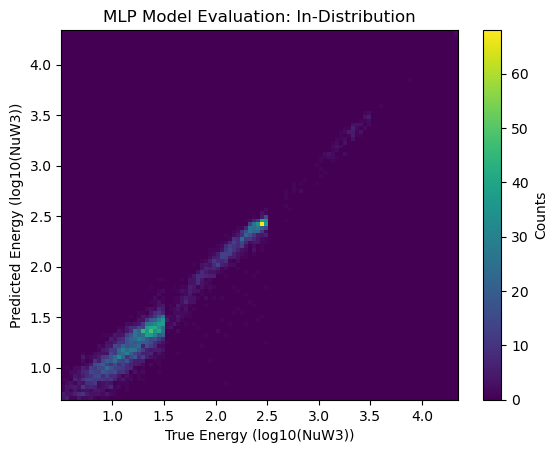

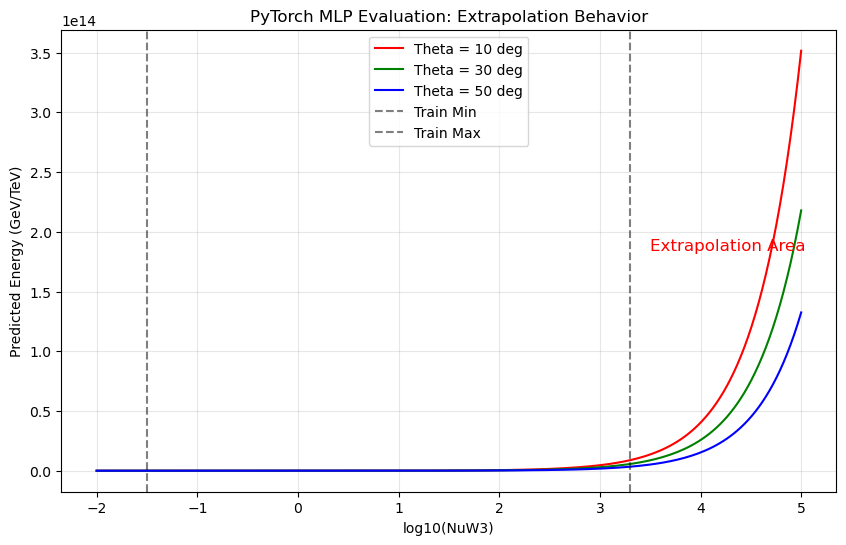

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1. 数据准备与预处理 (关键步骤！)
# ==========================================
# 假设 mn_df_train 已经按照你之前的代码准备好了
# X_train, X_test, y_train, y_test 来源于你之前的 train_test_split
# 这里为了演示，我重新构建一下 tensor 流程

# 提取数据 (确保是 numpy 数组)
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32) # PyTorch通常需要 (N, 1) 形状
y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)

# 【重要】神经网络必须进行特征归一化 (Standardization)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_np) # 在训练集上fit
X_test_scaled = scaler_X.transform(X_test_np)       # 用同样的参数transform测试集

# 转为 PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train_scaled)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_scaled)
y_test_tensor = torch.from_numpy(y_test_np)

# 创建 DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ==========================================
# 2. 定义 MLP 模型
# ==========================================
class EnergyPredictor(nn.Module):
    def __init__(self):
        super(EnergyPredictor, self).__init__()
        # 定义一个简单的3层全连接网络
        # 输入: 2 (NuW3, rec_theta) -> 隐藏层 64 -> 隐藏层 64 -> 输出 1
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),           # ReLU 允许线性外推
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)     # 回归问题最后一层通常没有激活函数(或是Identity)
        )
        
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyPredictor().to(device)

# ==========================================
# 3. 训练模型
# ==========================================
criterion = nn.MSELoss() # 回归通常用均方误差
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
loss_history = []

print("开始训练 MLP...")
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    loss_history.append(epoch_loss / len(train_loader))
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_history[-1]:.6f}")

# ==========================================
# 4. 评估模型准确性 (In-Distribution)
# ==========================================
model.eval()
with torch.no_grad():
    predictions_tensor = model(X_test_tensor.to(device))
    y_pred = predictions_tensor.cpu().numpy()

print("-" * 30)
print("MLP 模型评估结果:")
print("MAE:", mean_absolute_error(y_test_np, y_pred))
print("R^2:", r2_score(y_test_np, y_pred))
print("-" * 30)

plt.hist2d(y_test_np.flatten(), y_pred.flatten(), bins=100, cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('True Energy (log10(NuW3))')
plt.ylabel('Predicted Energy (log10(NuW3))')
plt.title('MLP Model Evaluation: In-Distribution')
plt.show()

# ==========================================
# 5. 评估范围外表现 (Extrapolation)
# ==========================================
# 生成假数据
fake_nuw3 = np.linspace(-2.0, 5.0, 200) # 覆盖范围更广
thetas_deg = [10, 30, 50]
thetas_rad = [t / 180 * np.pi for t in thetas_deg]

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']

train_min_nuw3, train_max_nuw3 = -1.5, 3.3 # 你的训练集范围参考

model.eval()
with torch.no_grad():
    for i, theta in enumerate(thetas_rad):
        # 1. 构造原始特征
        fake_X = np.column_stack((fake_nuw3, np.full_like(fake_nuw3, theta)))
        
        # 2. 【关键】使用训练集的scaler进行归一化
        fake_X_scaled = scaler_X.transform(fake_X.astype(np.float32))
        
        # 3. 转 Tensor 并预测
        fake_tensor = torch.from_numpy(fake_X_scaled).to(device)
        pred_log = model(fake_tensor).cpu().numpy().flatten()
        
        # 4. 还原能量
        pred_energy = (10 ** pred_log) * 1e8
        
        # 绘图
        plt.plot(fake_nuw3, pred_energy, color=colors[i], label=f'Theta = {thetas_deg[i]} deg')

# 辅助线
plt.axvline(x=train_min_nuw3, color='k', linestyle='--', alpha=0.5, label='Train Min')
plt.axvline(x=train_max_nuw3, color='k', linestyle='--', alpha=0.5, label='Train Max')
plt.text(train_max_nuw3 + 0.2, plt.ylim()[1]*0.5, 'Extrapolation Area', fontsize=12, color='red')

# plt.yscale('log')
plt.xlabel('log10(NuW3)')
plt.ylabel('Predicted Energy (GeV/TeV)')
plt.title('PyTorch MLP Evaluation: Extrapolation Behavior')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()


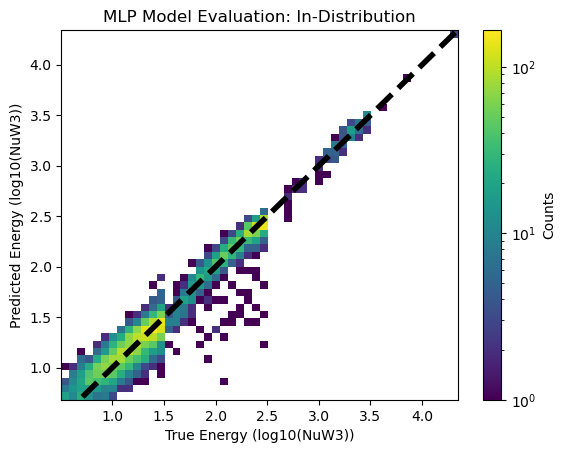

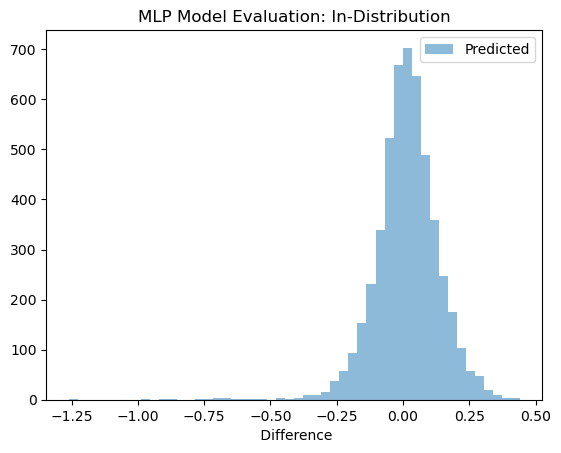

95% confidence interval: 0.8705061495304107 to 4.343170642852783


In [36]:
plt.hist2d(y_test_np.flatten(), y_pred.flatten(), bins=50, cmap='viridis', norm=LogNorm())
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--', lw=4)
plt.colorbar(label='Counts')
plt.xlabel('True Energy (log10(NuW3))')
plt.ylabel('Predicted Energy (log10(NuW3))')
plt.title('MLP Model Evaluation: In-Distribution')
plt.show()

plt.hist(y_pred.flatten()-y_test_np.flatten(), bins=50, alpha=0.5, label='Predicted')
plt.xlabel(' Difference')
plt.title('MLP Model Evaluation: In-Distribution')
plt.legend()
plt.show()

y_low, y_high = np.percentile(y_pred.flatten(), [5, 100])
print(f"95% confidence interval: {y_low} to {y_high}")
